In [ ]:
!pip install --upgrade pip

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

import re #특수문자 제거하기 위한 package
from bs4 import BeautifulSoup #html 파싱용 

In [2]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [65]:
df = pd.read_csv("data/IMDB_Dataset.csv")
df = df[:100]
df

TypeError: a bytes-like object is required, not 'Series'

In [83]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

result = []

for i in df['review'] :
    temp = BeautifulSoup(i, "html5lib") # html 태그 제거
    i = re.sub('[^a-zA-Z]',' ',temp.get_text()) # 정규표현식(알파벳 제외 문자 제거)
    stop_words = set(stopwords.words('english')) 
    
    word_tokens = word_tokenize(i) # 토큰화
    temp = []

    for w in word_tokens: 
        if w not in stop_words: # 불용어 제거
            temp.append(w)
    result.append(temp)

# print(word_tokens,'\n')
print(result[0])

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(result, df['sentiment'].values, random_state=42)

In [71]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

vocab_size = 1000
max_len = 30

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):

    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))

sequencer = TextsToSequences(num_words=vocab_size)

class Padder(BaseEstimator, TransformerMixin):

    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(max_len)

In [72]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1
epoch = 20
embedding_dim = 100
hidden_units = 128
    
def create_model(max_features):
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(LSTM(hidden_units))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model

lstm = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size=batch_size, 
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, lstm)

pipeline.fit(X_train, y_train);

<ipython-input-71-d799e6f226b5>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self.texts_to_sequences(texts))


Epoch 1/20
2/2 [==============================] - 3s 21ms/step - loss: 0.6913 - acc: 0.4800
Epoch 2/20
2/2 [==============================] - 0s 16ms/step - loss: 0.6526 - acc: 0.6400
Epoch 3/20
2/2 [==============================] - 0s 16ms/step - loss: 0.5550 - acc: 0.6800
Epoch 4/20
2/2 [==============================] - 0s 17ms/step - loss: 0.4513 - acc: 0.8267
Epoch 5/20
2/2 [==============================] - 0s 17ms/step - loss: 0.3415 - acc: 0.9333
Epoch 6/20
2/2 [==============================] - 0s 15ms/step - loss: 0.2205 - acc: 0.9733
Epoch 7/20
2/2 [==============================] - 0s 16ms/step - loss: 0.1798 - acc: 0.9867
Epoch 8/20
2/2 [==============================] - 0s 16ms/step - loss: 0.1542 - acc: 0.9867
Epoch 9/20
2/2 [==============================] - 0s 17ms/step - loss: 0.1303 - acc: 0.9867
Epoch 10/20
2/2 [==============================] - 0s 16ms/step - loss: 0.1080 - acc: 0.9867
Epoch 11/20
2/2 [==============================] - 0s 16ms/step - loss: 0.0830 

In [73]:
from sklearn import metrics
print('Computing predictions on test set...')
y_preds = pipeline.predict(X_test)

print('Test accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, y_test)))

Computing predictions on test set...


<ipython-input-71-d799e6f226b5>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self.texts_to_sequences(texts))
c:\users\jy\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 0s 413ms/step
Test accuracy: 44.00 %


In [92]:
dff = pd.read_csv("data/frozen_pre.csv", index_col = 0)
dff['star'] = dff[dff['star'] != '-']
dff['star'] = pd.to_numeric(dff['star'])
dff[dff['star'] >= 7]['sentiment'] = 1 # IMDB 데이터와 동일한 기준으로 긍/부정 라벨링
dff[dff['star'] < 5]['sentiment'] = 0
dff.head()

<ipython-input-92-0c9590259de3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[dff['star'] >= 7]['sentiment'] = 1
<ipython-input-92-0c9590259de3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[dff['star'] < 5]['sentiment'] = 0


,star,reply,reply_token,reply_ie
0,10.0,Believe the hype - Frozen is not just a fantas...,"['believe', 'hype', 'frozen', 'fantastic', 'di...","[220, 406, 5, 253, 2, 3, 253, 3, 623, 1182, 26..."
1,8.0,"This is really a lovely, enjoyable cartoon. An...","['really', 'lovely', 'enjoyable', 'cartoon', '...","[22, 765, 306, 314, 765, 306, 314, 570, 219, 1..."
2,10.0,When people speak of their favorite Disney mov...,"['people', 'speak', 'favorite', 'disney', 'mov...","[46, 641, 189, 2, 1, 106, 784, 465, 3, 796, 13..."
3,5.0,"First of all, I strongly disagree with any ass...","['first', 'strongly', 'disagree', 'assertion',...","[36, 1456, 2109, 4003, 5, 4004, 74, 25, 2, 3, ..."
4,10.0,A lot of people criticize Frozen for what it i...,"['lot', 'people', 'criticize', 'frozen', 'pref...","[84, 46, 1339, 5, 957, 144, 227, 430, 603, 260..."


In [96]:
# We choose a sample from test set
idx = 3
text_sample = dff.loc[idx, 'reply_token']
class_names = ['negative', 'positive']

print('Sample {}: last 80 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-80:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % y_test[idx])

Sample 3: last 80 words (only part used by the model)
--------------------------------------------------
'frozen', 'character', 'landscape', 'alike', 'excellent', 'tangle', 'much', 'satisfy', 'frozen', 'applaud', 'disney', 'hone', 'cgi', 'skill', 'finally', 'adapt', 'snow', 'queen', 'screen', 'wish', 'would', 'spent', 'time', 'script', 'film', 'like', 'one', 'distinction', 'need', 'make', 'love', 'visceral', 'takeaway', 'sweet', 'great', 'message', 'make', 'feel', 'good', 'look', 'critical', 'standpoint', 'understand', 'one', 'need', 'forget', 'critical', 'enjoy', 'film', 'best', 'film', 'take', 'care', 'one', 'like', 'frozen', 'seem', 'like', 'clearly', 'could', 'much', 'well', 'get', 'think', 'film', 'fun', 'one', 'kid', 'great', 'look', 'adult', 'far', 'short', 'great', 'masterpiece', 'focus', 'truly', 'excellent', 'story', 'might']
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
Probability(positive) = 0.9411893
True class: pos

79/79 [==============================] - 1s 11ms/step


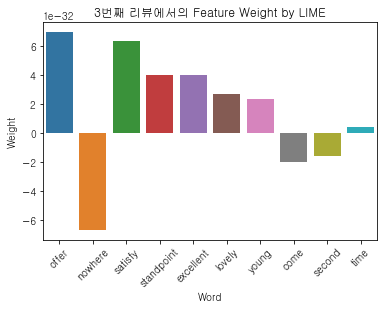

In [112]:
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'Word': list(weights.keys()), 'Weight': list(weights.values())})

sns.barplot(x="Word", y="Weight", data=lime_weights);
plt.xticks(rotation=45)
plt.title(str(idx) + '번째 리뷰에서의 Feature Weight by LIME');